# Part C: Spatial clustering


### Procedure:
1. Select a city C and select all POIs of type P (e.g., banks, restaurants, clinics) in C.
2. Download the selected Ps from OpenStreetMap.
3. Plot a folium map showing Ps over a base map of your choice.
4. Perform a cluster analysis over Ps, calculating the number of clusters using the
Elbow method
Coursework2 – Page 4 of 5
5. Report the number of clusters and the number of elements per cluster.
6. Plot a folium map showing Ps now coloured by cluster ID and cluster's centroids.
7. Based on your selected Ps, add relevant information to decide possible redundant points. For example, if you select restaurants, you can add a column “type of food”.
If you have many restaurants of the same type of food in the same cluster, you can
remove the ones with small profit margins.
8. Redo the cluster analysis with the remaining Ps.
9. Plot a new folium map with the clusters obtained in point 8.

### 1. Select a city C and select all POIs of type P (e.g., banks, restaurants, clinics) in C.

C = Greater London 

C will be accessed using the OMS wikidata code Q23306

P = Santander Cycles Docking Stations

### 2. Download the selected Ps from OpenStreetMap.

In [1]:
# importing the relevant libraries

# uncomment the following line to install 'overpy'
#!pip install overpy

import overpy #library allows you to query OpenStreetMap data using the Overpass API
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import folium

from sklearn import preprocessing, cluster
import scipy

In [2]:
# loading POI data from OpenStreetMap using Overpass API 
# as per: https://blog.devgenius.io/loading-poi-data-from-openstreetmap-using-overpass-api-b287ed809ed8

# "wikidata" = "Q23306" -> Greater London OSM boundary code

api = overpy.Overpass()

P = api.query("""
    area["wikidata" = "Q23306"]->.place;   
    node[amenity = bicycle_rental][bicycle_rental = docking_station][brand = "Santander Cycles"](area.place);
    (._;>;);
    out body;
    """)

There are three OSM data types: 1) node, 2) way 3) relation.

Importantly, some POI might be stored as ways rather than nodes. Where appropriate, use the 'out centre' statement in the query; for each way and relation to determine a centre coordinate stored under the centre key, as per: https://janakiev.com/blog/openstreetmap-with-python-and-overpass-api/

In [3]:
from shapely.geometry import Point

# creating a geodataframe using the POI data
points_array = [ Point(x.lon, x.lat) for x in P.nodes]
points_series = gpd.GeoSeries(points_array)

monuments_array = [ { 
    "name": x.tags.get("name", ""),
} for x in P.nodes]

sc_gdf = gpd.GeoDataFrame(monuments_array, geometry=points_series, crs=4326)

sc_gdf

name                   geometry
0             Windsor Terrace  POINT (-0.09339 51.52913)
1                Pancras Road  POINT (-0.12924 51.53404)
2               Ampton Street  POINT (-0.11824 51.52729)
3                 Bath Street  POINT (-0.09084 51.52583)
4           St. Chad's Street  POINT (-0.12106 51.53002)
..                        ...                        ...
776                  The Blue  POINT (-0.06251 51.49222)
777          Crimscott Street  POINT (-0.07886 51.49560)
778            Harris Academy  POINT (-0.07241 51.49270)
779             Clements Road  POINT (-0.06171 51.49542)
780  South Bermondsey Station  POINT (-0.05776 51.48803)

[781 rows x 2 columns]

In [4]:
# adding lat and lon columns based on the values in the geometry column
sc_gdf['lat'] = sc_gdf['geometry'].y
sc_gdf['lon'] = sc_gdf['geometry'].x

In [5]:
sc_gdf

name                   geometry        lat       lon
0             Windsor Terrace  POINT (-0.09339 51.52913)  51.529125 -0.093388
1                Pancras Road  POINT (-0.12924 51.53404)  51.534038 -0.129244
2               Ampton Street  POINT (-0.11824 51.52729)  51.527292 -0.118235
3                 Bath Street  POINT (-0.09084 51.52583)  51.525828 -0.090836
4           St. Chad's Street  POINT (-0.12106 51.53002)  51.530015 -0.121057
..                        ...                        ...        ...       ...
776                  The Blue  POINT (-0.06251 51.49222)  51.492216 -0.062512
777          Crimscott Street  POINT (-0.07886 51.49560)  51.495596 -0.078862
778            Harris Academy  POINT (-0.07241 51.49270)  51.492702 -0.072414
779             Clements Road  POINT (-0.06171 51.49542)  51.495419 -0.061715
780  South Bermondsey Station  POINT (-0.05776 51.48803)  51.488027 -0.057759

[781 rows x 4 columns]

### 3. Plot a folium map showing Ps over a base map of your choice.

In [6]:
# creating a folium map 

m = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="CartoDB dark_matter", # adding a dark basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the base map
)

In [7]:
# iterate through every row of the dataframe using the iterrows() function
for index, val in sc_gdf.iterrows():
    folium.CircleMarker(
        location=[val["lat"], val["lon"]],
        # styling the circles with different parameters 
        radius=5,
        popup= val["name"],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    # adding all circles to the map
    ).add_to(m)


m

### 4. Perform a cluster analysis over Ps, calculating the number of clusters using the Elbow method

'Clustering is the task of grouping a set of objects in such a way that observations in the same group are more similar to each other than to those in other groups. It is one of the most popular applications of the Unsupervised Learning (Machine Learning when there is no target variable).' as per: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

The elbow method is a technique used to determine the optimal number of clusters for a given dataset when using k-means clustering.

C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

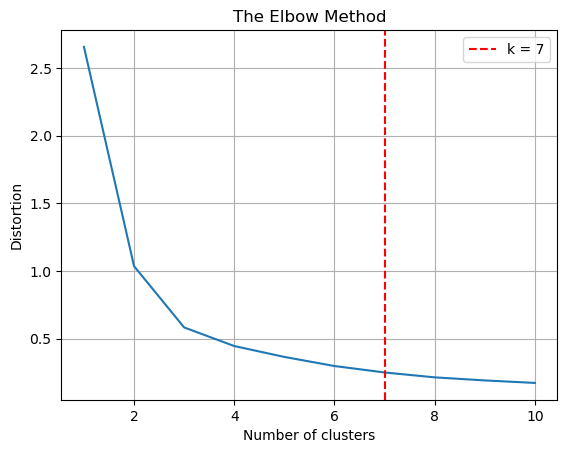

In [8]:
# the following code is adopted from Lecture 10 - Spatial Clustering

# determine the number of clusters using the Elbow method
X = sc_gdf[["lat","lon"]]
max_k = 10
# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

### 5. Report the number of clusters and the number of elements per cluster.

In [9]:
print("Elbow method returns " + str(k) + " clusters")

Elbow method returns 7 clusters


In [10]:
# creating the clusters 
model = cluster.KMeans(n_clusters=k, init='k-means++')
#X = sc_gdf[["lat","lon"]]
X = sc_gdf[["lon","lat"]]

# clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
# add clustering info to the original dataset, cluster label and centroid cluster label
sc_gdf[["cluster","centroids"]] = df_X[["cluster","centroids"]]
sc_gdf.sample(5)

C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\1796388752.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X["centroids"].iloc[i] = 1


name                   geometry        lat       lon  cluster  \
145  Earnshaw Street  POINT (-0.12859 51.51611)  51.516110 -0.128589        0   
505  Sandilands Road  POINT (-0.19172 51.47362)  51.473618 -0.191718        5   
272     Derry Street  POINT (-0.19157 51.50141)  51.501410 -0.191565        3   
597    Holden Street  POINT (-0.15824 51.46878)  51.468782 -0.158236        5   
89     Tower Gardens  POINT (-0.07539 51.50953)  51.509530 -0.075386        2   

     centroids  
145          0  
505          0  
272          0  
597          0  
89           0

<AxesSubplot: xlabel='cluster', ylabel='count'>

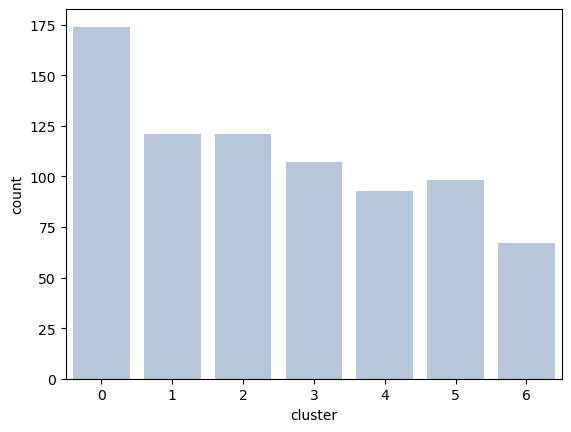

In [11]:
# seaborn countplot of cluster counts 
sns.countplot(x=sc_gdf["cluster"], color = 'lightsteelblue')

In [12]:
# number of elements per cluster
# using the groupby() and size() functions to reveal the number of clusters and the number of elements per cluster.
print(sc_gdf.groupby('cluster').size())

cluster
0    174
1    121
2    121
3    107
4     93
5     98
6     67
dtype: int64


### 6. Plot a folium map showing Ps now coloured by cluster ID and cluster's centroids.

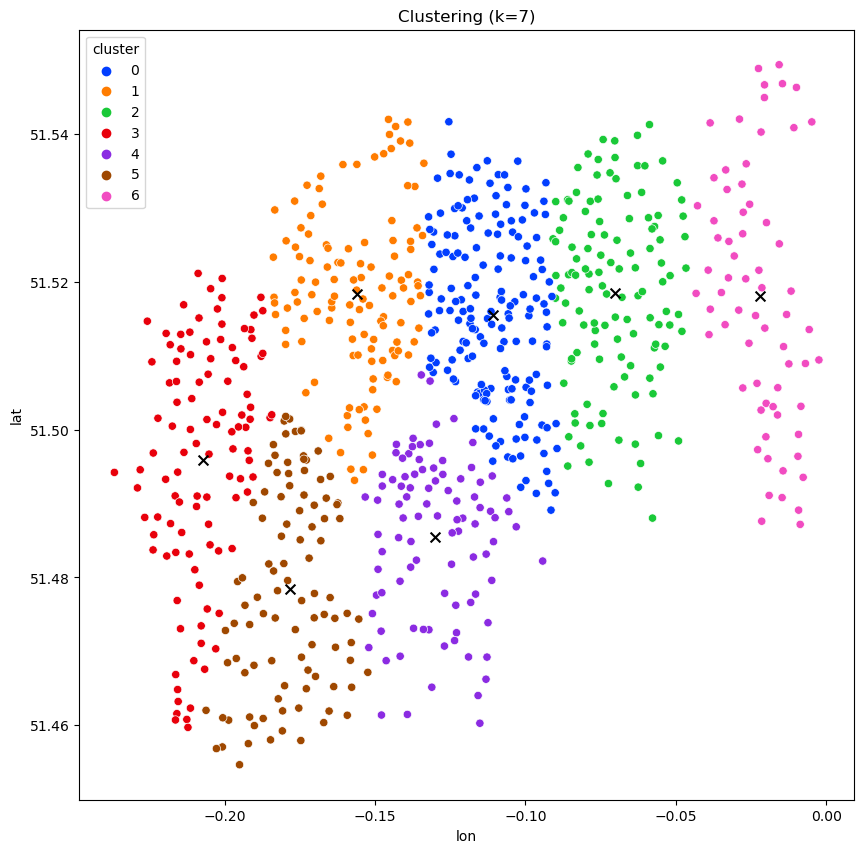

In [13]:
# plotting the clustering and cluster centroids on a static plot

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x="lon", y="lat", data=sc_gdf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', #size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [14]:
# plotting the spatial clustering on an interactive map

map_ = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="cartodbpositron", # adding a basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the basemap
)

color = "cluster"
marker = "centroids"
data = sc_gdf.copy()

lst_elements = sorted(list(data[color].unique()))
#lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] # code to generate colours at random
lst_colors=["blue","orange","green","red","magenta", "brown","pink","yellow", "darkpurple","lightgreen", "gray", "black"] 
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

scaler = preprocessing.MinMaxScaler(feature_range=(3,15))

# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row["lat"],row["lon"]],
           popup=row['name'], # for popup
           color=row["color"], fill=True).add_to(map_), axis=1)

  
# adding a html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))


# add centroids marker as an icon
lst_elements = sorted(list(data[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row["lat"],row["lon"]], 
           popup='<strong>'+'Cluster: ' + str(row['cluster']), 
            draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
# plot the map
map_


### 7. Based on your selected Ps, add relevant information to decide possible redundant points. For example, if you select restaurants, you can add a column “type of food”. If you have many restaurants of the same type of food in the same cluster, you can remove the ones with small profit margins.

The following code is adopted from 'Clustering Geospatial Data' by Mauro Di Pietro https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

Generating random synthetic performance information for docking stations:
1) Usage - integer between 50 and 10000
2) Cost - low, medium, high

- Reduntant docking stations are considered to have the low useage and high cost

Scope: Remove 40% of low usage high cost docking stations, ensuring removing is proportional to the number of docking stations in the cluster to ensure a reasonable coverage is maintained.

In [15]:
# adding synthetic usage data 
sc_gdf["usage"] = np.random.randint(low=50, high=10000, size=len(sc_gdf))
# adding synthetic cost data 
sc_gdf["cost"] = np.random.choice(["high","medium","low"], size=len(sc_gdf), p=[0.5,0.3,0.2])

In [16]:
sc_gdf.groupby('cluster').size()

cluster
0    174
1    121
2    121
3    107
4     93
5     98
6     67
dtype: int64

In [17]:
# adding the cluster count totals to the dataframe 
sc_gdf["clust_count"] = sc_gdf.groupby('cluster')['cluster'].transform("count")
sc_gdf

name                   geometry        lat       lon  \
0             Windsor Terrace  POINT (-0.09339 51.52913)  51.529125 -0.093388   
1                Pancras Road  POINT (-0.12924 51.53404)  51.534038 -0.129244   
2               Ampton Street  POINT (-0.11824 51.52729)  51.527292 -0.118235   
3                 Bath Street  POINT (-0.09084 51.52583)  51.525828 -0.090836   
4           St. Chad's Street  POINT (-0.12106 51.53002)  51.530015 -0.121057   
..                        ...                        ...        ...       ...   
776                  The Blue  POINT (-0.06251 51.49222)  51.492216 -0.062512   
777          Crimscott Street  POINT (-0.07886 51.49560)  51.495596 -0.078862   
778            Harris Academy  POINT (-0.07241 51.49270)  51.492702 -0.072414   
779             Clements Road  POINT (-0.06171 51.49542)  51.495419 -0.061715   
780  South Bermondsey Station  POINT (-0.05776 51.48803)  51.488027 -0.057759   

     cluster  centroids  usage    cost  clust_count  
0          0          0    447  medium          174  
1          0          0   5506    high          174  
2          0          0   7146     low          174  
3          2          0   5358  medium          121  
4          0          0   9671     low          174  
..       ...        ...    ...     ...          ...  
776        2          0    623  medium          121  
777        2          0   1832    high          121  
778        2          0   9850    high          121  
779        2          0   7031    high          121  
780        2          0   2445    high          121  

[781 rows x 9 columns]

In [18]:
# data exploration - creating an interactive folium plot with the size of points proportional to usage and coloured by cost
# as per: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

map_UC = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="cartodbpositron", # adding a basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the base map
)

color = "cost"
size = "usage"
data = sc_gdf.copy()

# create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(data[color].unique()))
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

# create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)


# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row["lat"],row["lon"]],
           # customising the popup, displaying relevant attributes 
           popup="Name: "+ row['name'] + 
           " <br> Cost: " + row['cost'] + 
           " <br> Usage: " + str(row["usage"]), # for popup
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_UC), axis=1)

  
# adding a html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_UC.get_root().html.add_child(folium.Element(legend_html))


# plot the map
map_UC

In [19]:
# filtering the dataframe to high cost only 
sc_gdf_high = sc_gdf[sc_gdf["cost"]=="high"]

In [20]:
sc_gdf_high

name                   geometry        lat       lon  \
1                Pancras Road  POINT (-0.12924 51.53404)  51.534038 -0.129244   
5              Margery Street  POINT (-0.11240 51.52661)  51.526610 -0.112402   
10        Borough High Street  POINT (-0.09452 51.50062)  51.500619 -0.094516   
13              Braham Street  POINT (-0.07358 51.51412)  51.514120 -0.073575   
14               Leman Street  POINT (-0.06941 51.51225)  51.512250 -0.069410   
..                        ...                        ...        ...       ...   
774  Burgess Park Albany Road  POINT (-0.09428 51.48221)  51.482215 -0.094276   
777          Crimscott Street  POINT (-0.07886 51.49560)  51.495596 -0.078862   
778            Harris Academy  POINT (-0.07241 51.49270)  51.492702 -0.072414   
779             Clements Road  POINT (-0.06171 51.49542)  51.495419 -0.061715   
780  South Bermondsey Station  POINT (-0.05776 51.48803)  51.488027 -0.057759   

     cluster  centroids  usage  cost  clust_count  
1          0          0   5506  high          174  
5          0          0   4939  high          174  
10         0          0   5323  high          174  
13         2          0   9599  high          121  
14         2          0   4537  high          121  
..       ...        ...    ...   ...          ...  
774        4          0   4771  high           93  
777        2          0   1832  high          121  
778        2          0   9850  high          121  
779        2          0   7031  high          121  
780        2          0   2445  high          121  

[394 rows x 9 columns]

In [21]:
# rationalisation of high cost low usage docking stations,
# ensuring removal is proportional to the total number of docking cluster

df_new = pd.DataFrame()

for c in sorted(sc_gdf_high["cluster"].unique()):
    # creating a dataframe of each cluster iteration
    df_cluster = sc_gdf_high[sc_gdf_high["cluster"]==c]
    clust_count = df_cluster['clust_count'].iloc[0]
  
    # determine the number of docking stations to be removed from each cluster  
    drop_num = round(clust_count*0.4) # 40% of each clsuter total
    
    # order dataframe by usages
    df_cluster = df_cluster.sort_values(by=['usage'], ascending=False)
    
    # dropping rows based on drop number
    df_cluster = df_cluster.head(-(drop_num))
    
    # create a new dataframe of high cost docking stations having removed the lowest usage docks
    df_new = df_new.append(pd.DataFrame(df_cluster))
    
df_new   

C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\385576191.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_cluster))
C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\385576191.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_cluster))
C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\385576191.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_cluster))
C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\385576191.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_cl

name                   geometry        lat       lon  \
305           Frith Street  POINT (-0.13120 51.51310)  51.513104 -0.131201   
206    St. Martin's Street  POINT (-0.12975 51.50908)  51.509076 -0.129745   
456        Houghton Street  POINT (-0.11672 51.51354)  51.513538 -0.116719   
478          Waterloo Road  POINT (-0.11290 51.50487)  51.504872 -0.112905   
204          Craven Street  POINT (-0.12591 51.50804)  51.508042 -0.125915   
..                     ...                        ...        ...       ...   
409            Newby Place  POINT (-0.01241 51.50890)  51.508899 -0.012410   
490  Fisherman's Walk West  POINT (-0.02301 51.50627)  51.506269 -0.023008   
496            Alpha Grove  POINT (-0.02279 51.49729)  51.497289 -0.022788   
685          Stainsby Road  POINT (-0.02349 51.51543)  51.515435 -0.023485   
397           Langdon Park  POINT (-0.01317 51.51559)  51.515589 -0.013166   

     cluster  centroids  usage  cost  clust_count  
305        0          0   9787  high          174  
206        0          0   9362  high          174  
456        0          0   9250  high          174  
478        0          0   8887  high          174  
204        0          0   8862  high          174  
..       ...        ...    ...   ...          ...  
409        6          0   9900  high           67  
490        6          0   9544  high           67  
496        6          0   9147  high           67  
685        6          0   8972  high           67  
397        6          0   8954  high           67  

[82 rows x 9 columns]

In [22]:
# creating a dataframe that excludes high cost
sc_gdf_updated = sc_gdf[sc_gdf["cost"]!="high"]

# appending the rationalised high cost docking stations to the dataframe
sc_gdf_updated = sc_gdf_updated.append(pd.DataFrame(df_new))

sc_gdf_updated = sc_gdf_updated.drop(['cluster', 'centroids'], axis=1)

sc_gdf_updated

C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\3801326279.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sc_gdf_updated = sc_gdf_updated.append(pd.DataFrame(df_new))


name                   geometry        lat       lon  \
0          Windsor Terrace  POINT (-0.09339 51.52913)  51.529125 -0.093388   
2            Ampton Street  POINT (-0.11824 51.52729)  51.527292 -0.118235   
3              Bath Street  POINT (-0.09084 51.52583)  51.525828 -0.090836   
4        St. Chad's Street  POINT (-0.12106 51.53002)  51.530015 -0.121057   
6              Bunhill Row  POINT (-0.08989 51.52086)  51.520860 -0.089885   
..                     ...                        ...        ...       ...   
409            Newby Place  POINT (-0.01241 51.50890)  51.508899 -0.012410   
490  Fisherman's Walk West  POINT (-0.02301 51.50627)  51.506269 -0.023008   
496            Alpha Grove  POINT (-0.02279 51.49729)  51.497289 -0.022788   
685          Stainsby Road  POINT (-0.02349 51.51543)  51.515435 -0.023485   
397           Langdon Park  POINT (-0.01317 51.51559)  51.515589 -0.013166   

     usage    cost  clust_count  
0      447  medium          174  
2     7146     low          174  
3     5358  medium          121  
4     9671     low          174  
6     5496     low          121  
..     ...     ...          ...  
409   9900    high           67  
490   9544    high           67  
496   9147    high           67  
685   8972    high           67  
397   8954    high           67  

[469 rows x 7 columns]

In [23]:
print("Rationalisation of Santandar Cycle docking stations has resulted in the removal of " 
      + str(len(sc_gdf)-len(sc_gdf_updated))
      + " docks. That's " 
      + str(round((((len(sc_gdf)-len(sc_gdf_updated))/len(sc_gdf))*100),0)) 
      + "%")
      

Rationalisation of Santandar Cycle docking stations has resulted in the removal of 312 docks. That's 40.0%


### 8. Redo the cluster analysis with the remaining Ps.

C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

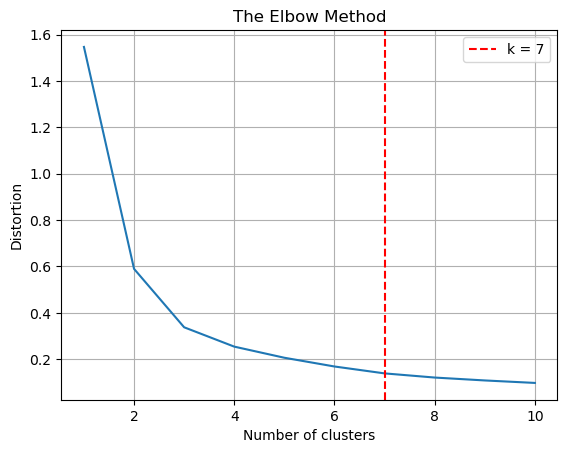

In [24]:
# determine the number of clusters using the Elbow method.
X = sc_gdf_updated[["lat","lon"]]
max_k = 10
# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
# plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [25]:
print("Following the removal redundant docks, the Elbow method now returns " + str(k) + " clusters")

Following the removal redundant docks, the Elbow method now returns 7 clusters


As we removed docking stations proportionally by cluster, the Elbow method again returns 7 clusters

In [26]:
# creating the clusters 
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = sc_gdf_updated[["lat","lon"]]
# clustering
sc_gdf_updated_X = X.copy()
sc_gdf_updated_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     sc_gdf_updated_X.drop("cluster", axis=1).values)
sc_gdf_updated_X["centroids"] = 0
for i in closest:
    sc_gdf_updated_X["centroids"].iloc[i] = 1
    
# add clustering info to the original dataset, cluster label and centroid cluster label
sc_gdf_updated[["cluster","centroids"]] = sc_gdf_updated_X[["cluster","centroids"]]
sc_gdf_updated.sample(5)

C:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\EMoses\AppData\Local\Temp\ipykernel_50712\553902911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_gdf_updated_X["centroids"].iloc[i] = 1


name                   geometry        lat       lon  \
216         St. John Street  POINT (-0.10472 51.52827)  51.528267 -0.104716   
166  Natural History Museum  POINT (-0.17908 51.49557)  51.495574 -0.179076   
358         South Quay East  POINT (-0.01618 51.50199)  51.501987 -0.016183   
173    Eaton Square (South)  POINT (-0.15390 51.49458)  51.494580 -0.153904   
51             Hinde Street  POINT (-0.15190 51.51681)  51.516812 -0.151897   

     usage    cost  clust_count  cluster  centroids  
216   4958  medium          174        0          0  
166   7820    high           98        3          0  
358    742  medium           67        5          0  
173   2555     low          121        1          0  
51    1328     low          121        1          0

### 9. Plot a new folium map with the clusters obtained in point 8.

In [27]:
# plotting the spatial clusting on an interactive map with redundant Santandar cycles docking stations removed

map_ = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="cartodbpositron", # adding a basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the base map
)

color = "cluster"
marker = "centroids"
data = sc_gdf_updated.copy()
data_original = sc_gdf.copy()

lst_elements = sorted(list(data[color].unique()))
# creating a list of ramdon colours
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] 
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
#data["size"] = scaler.fit_transform(
               #data[size].values.reshape(-1,1)).reshape(-1)

# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row["lat"],row["lon"]],
           popup=row['name'], # for popup
           color=row["color"], fill=True).add_to(map_), axis=1)
           #radius=row["size"]).add_to(map_), axis=1)

# adding html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))


# add centroids marker as an icon
lst_elements = sorted(list(data[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row["lat"],row["lon"]], 
           popup='<strong>'+'Cluster: ' + str(row['cluster']), 
            draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)



# plot the map
map_


Since redundant docking stations were removed proportionally to total within each cluster, we've managed to maintaine a relatively homogeneous coverage. Therefore, users won’t need to travel far to find a docking station

For comparison, let's add the original cluster locations as markers

In [28]:
# add centroids marker as an icon for the orginal data, coloured red
lst_elements = sorted(list(data_original[marker].unique()))
data_original[data_original[marker]==1].apply(lambda row: 
           folium.Marker(location=[row["lat"],row["lon"]], 
           popup='<strong>'+'Original cluster: ' + str(row['cluster']), 
           draggable=False,
           icon=folium.Icon(icon='star',color="red")).add_to(map_), axis=1)

map_
